<a href="https://colab.research.google.com/github/Adithyan773/IKEA_recomendation_system/blob/main/IKEA_BLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of rows after removing duplicates: 1024
Number of valid image paths: 1024
Number of rows after filtering by valid images: 1024


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Processing batch 1/64
Processing batch 2/64
Processing batch 3/64
Processing batch 4/64
Processing batch 5/64
Processing batch 6/64
Processing batch 7/64
Processing batch 8/64
Processing batch 9/64
Processing batch 10/64
Processing batch 11/64
Processing batch 12/64
Processing batch 13/64
Processing batch 14/64
Processing batch 15/64
Processing batch 16/64
Processing batch 17/64
Processing batch 18/64
Processing batch 19/64
Processing batch 20/64
Processing batch 21/64
Processing batch 22/64
Processing batch 23/64
Processing batch 24/64
Processing batch 25/64
Processing batch 26/64
Processing batch 27/64
Processing batch 28/64
Processing batch 29/64
Processing batch 30/64
Processing batch 31/64
Processing batch 32/64
Processing batch 33/64
Processing batch 34/64
Processing batch 35/64
Processing batch 36/64
Processing batch 37/64
Processing batch 38/64
Processing batch 39/64
Processing batch 40/64
Processing batch 41/64
Processing batch 42/64
Processing batch 43/64
Processing batch 44/

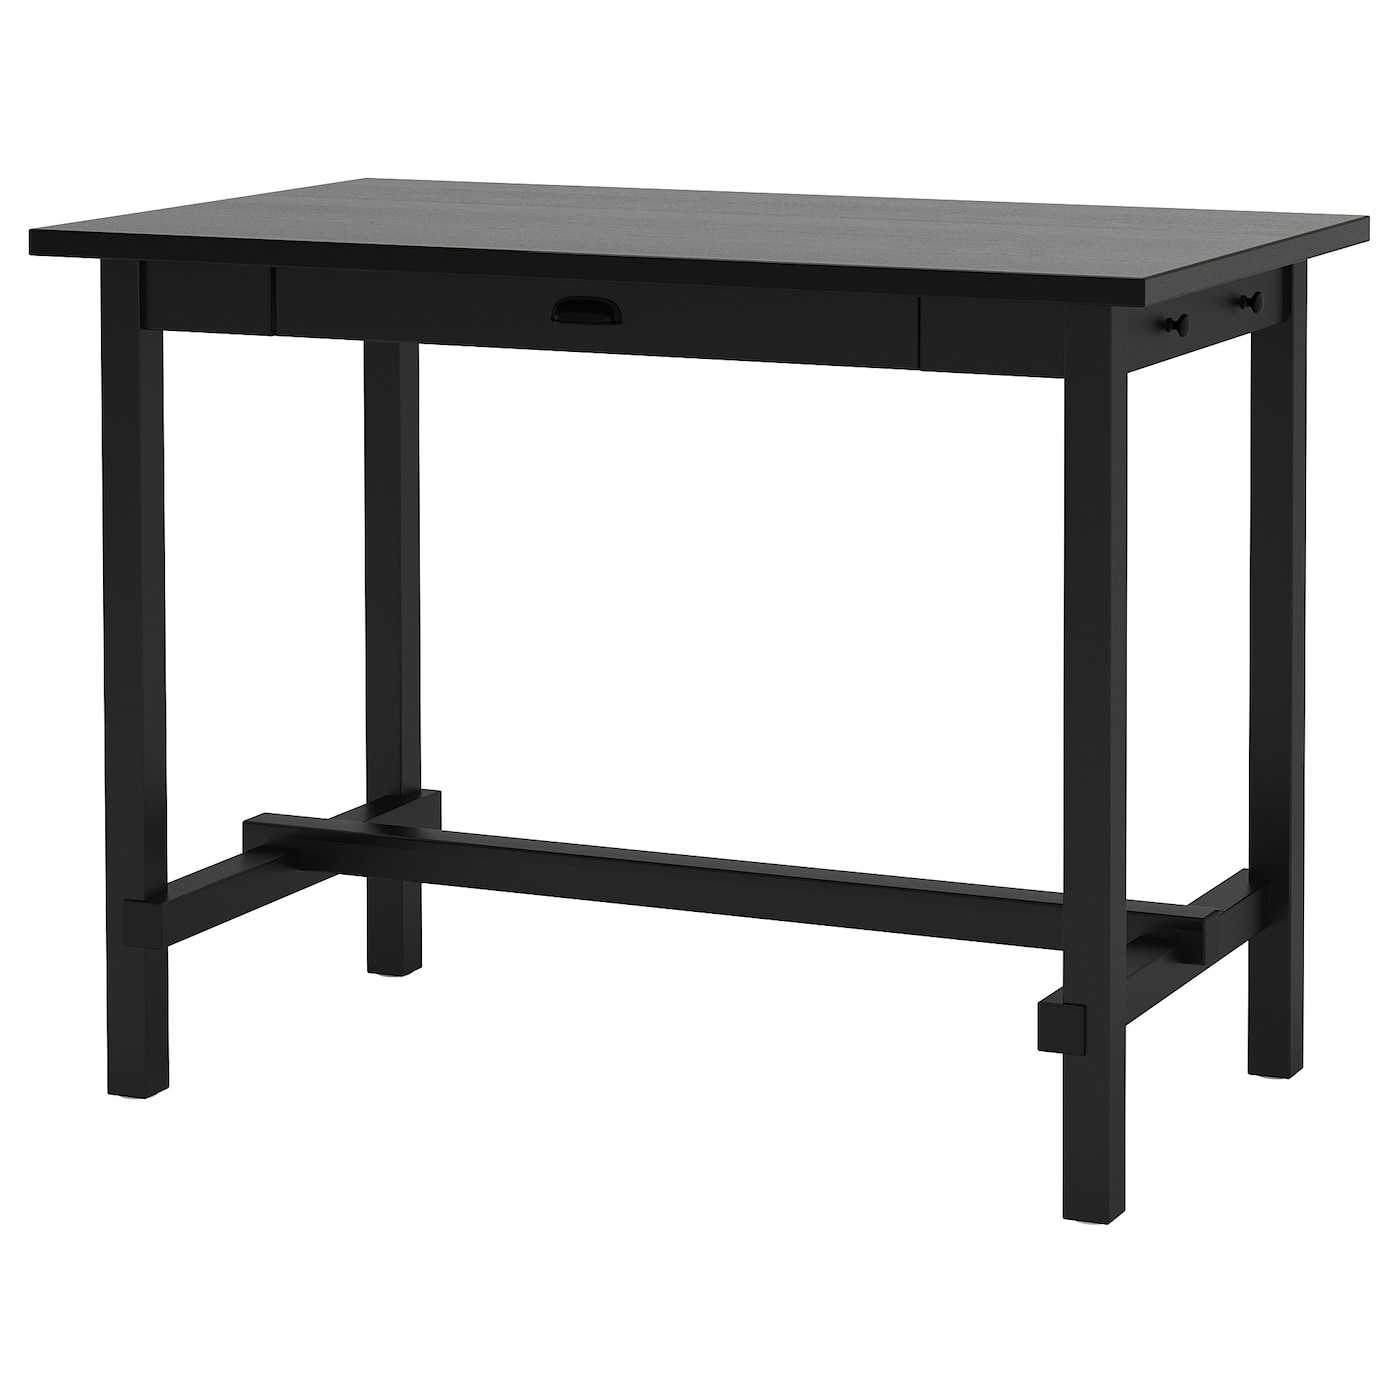

Item ID: 9333523
Description: a close up of a table with four chairs and a stool


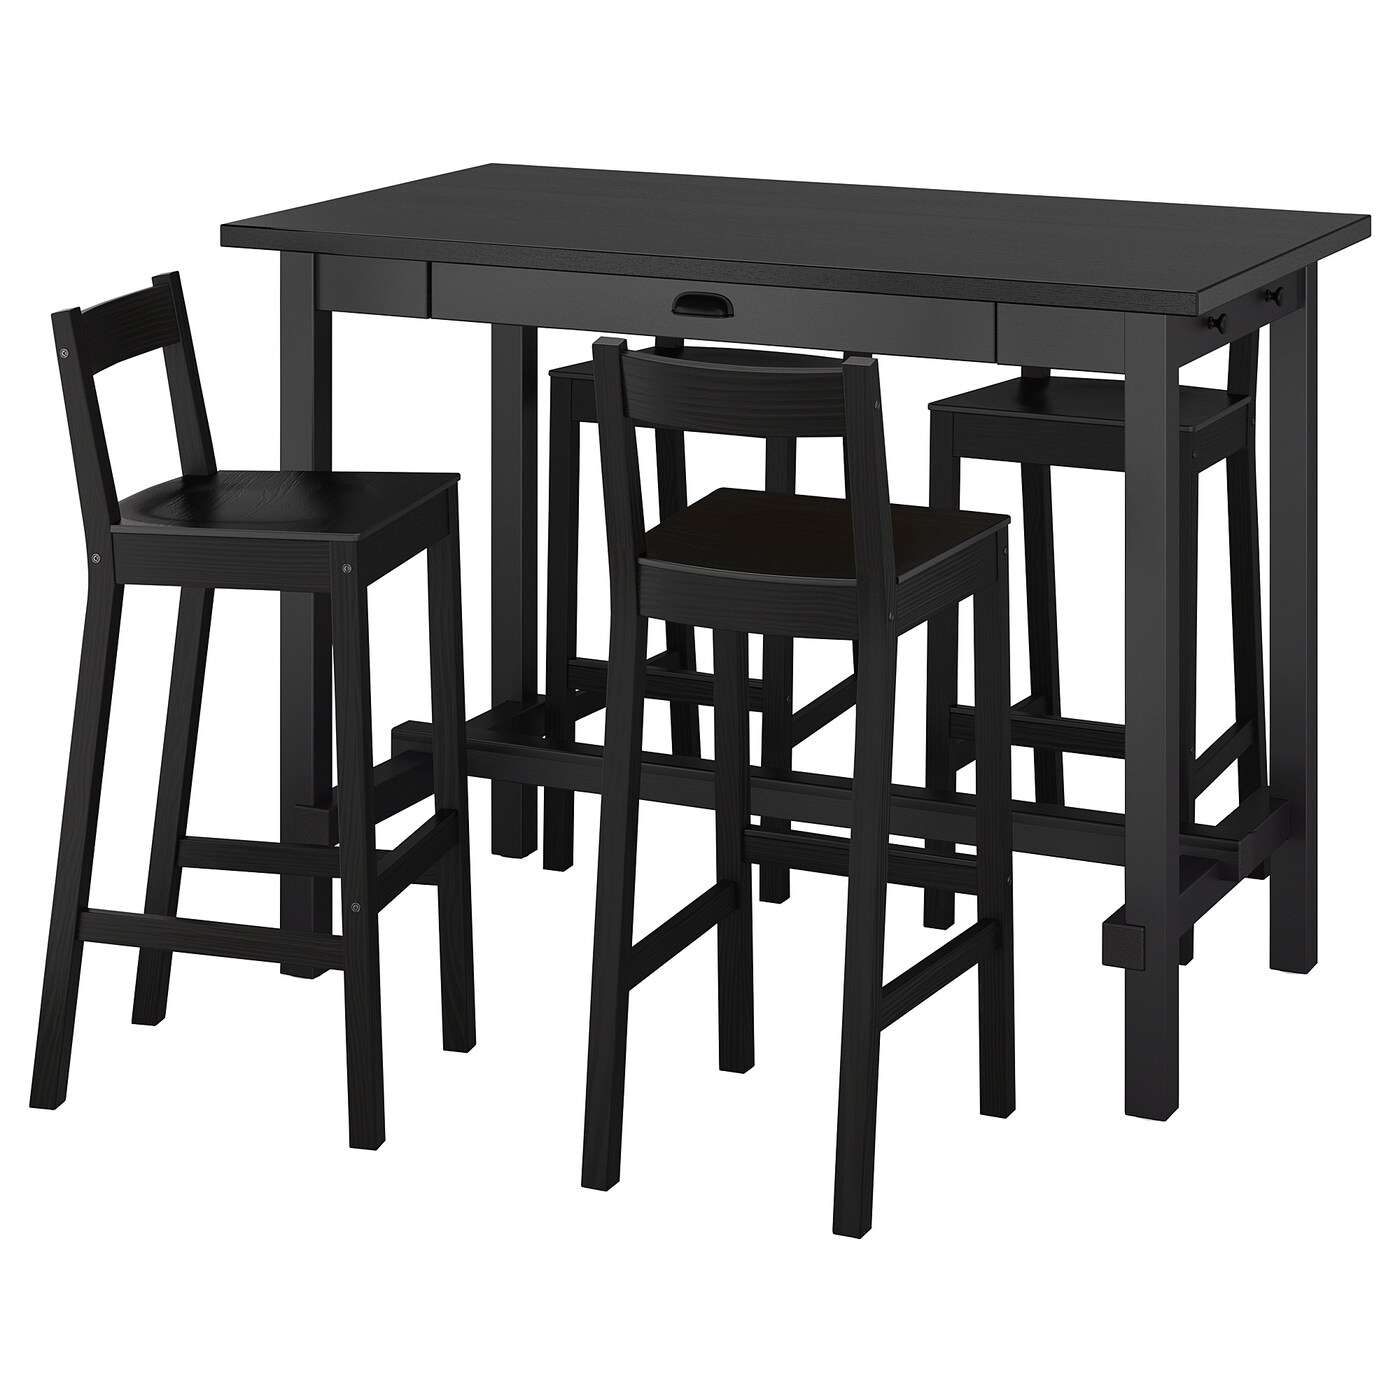

Item ID: 30180504
Description: there is a white table with a metal base and a white table top


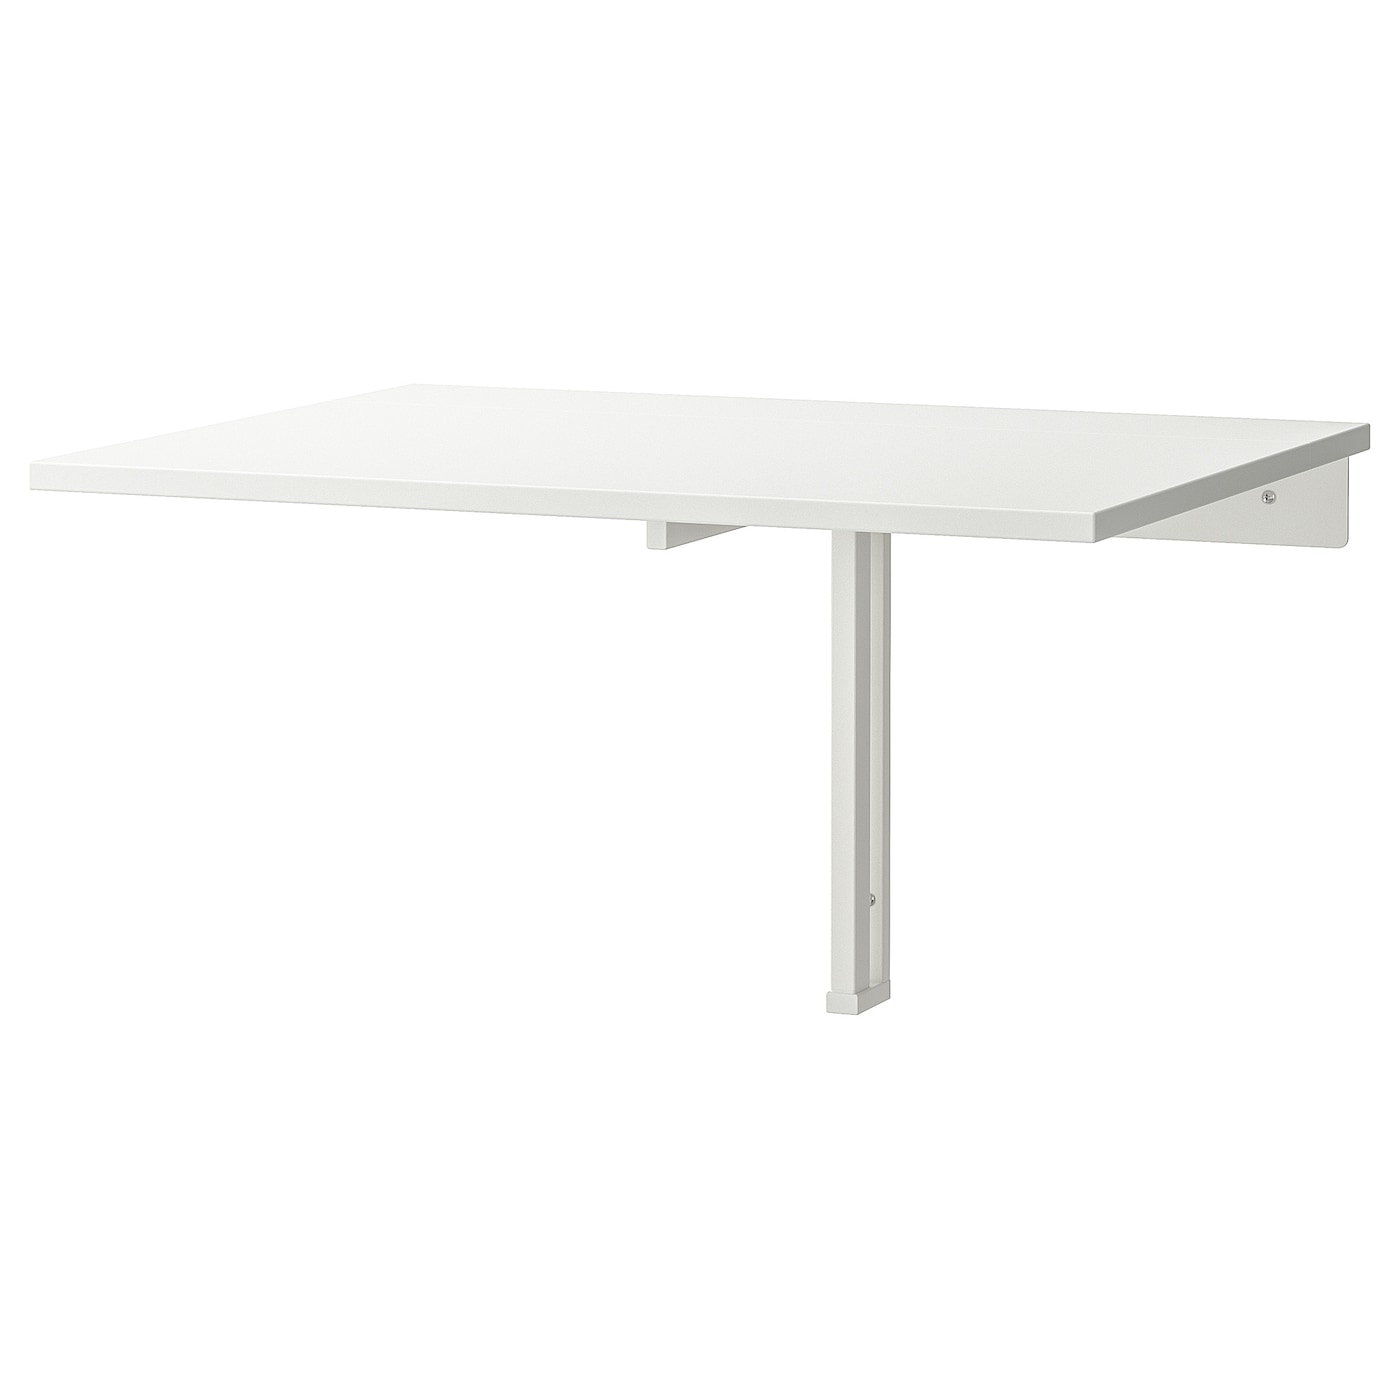

Item ID: 10122647
Description: a close up of a white stool with a wooden seat


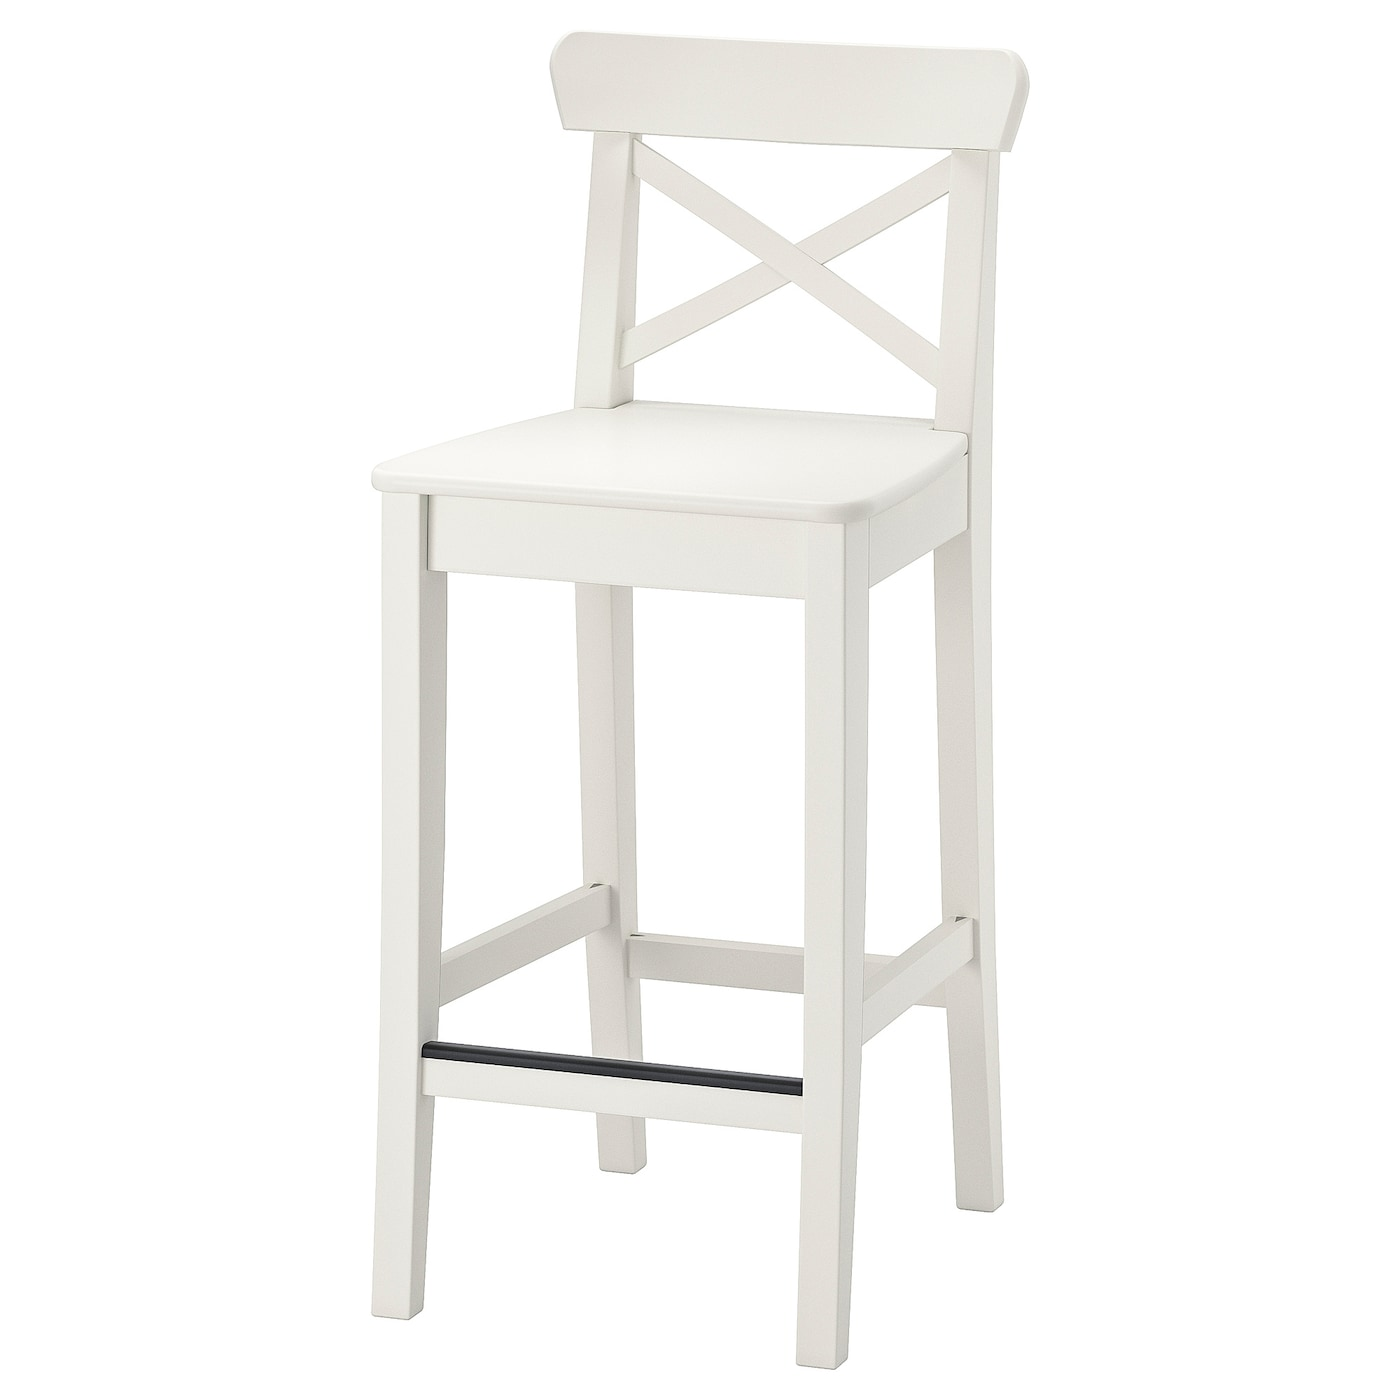

Item ID: 70404875
Description: a close up of a white chair with a metal frame


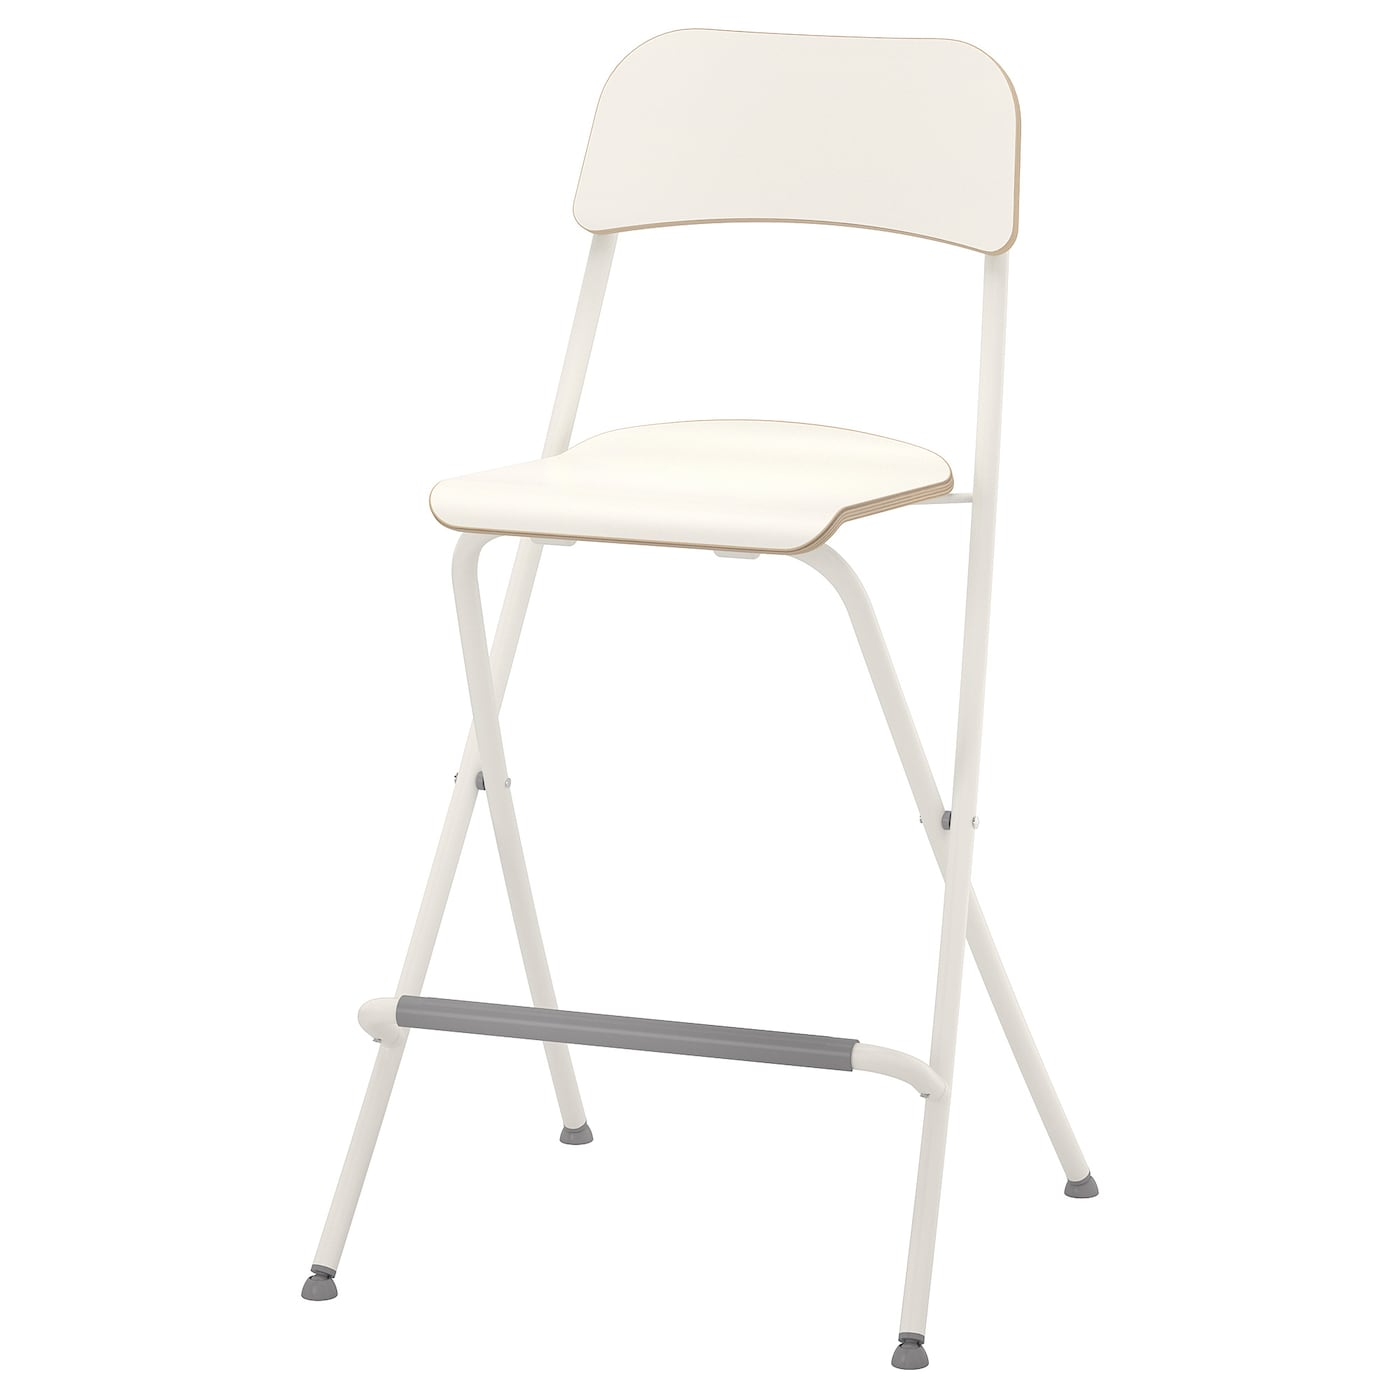

Updated dataset saved to: /content/ikea_data_img_fixed.csv


In [ ]:
import numpy as np
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image as PILImage
from IPython.display import display
import os
import torch
from torch.utils.data import DataLoader, Dataset
from google.colab import drive



# Load the DataFrame
df = pd.read_csv('/content/ikea_data_with_images.csv')
df['item_id'] = df['item_id'].astype(str)
df = df[df['item_id'] != 'nan']
df = df.drop_duplicates(subset='item_id', keep='first')
print(f"Number of rows after removing duplicates: {len(df)}")

# Define image directory
image_dir = '/content/drive/MyDrive/images/images'

# Generate and filter image paths
image_paths = [os.path.join(image_dir, f"{row['item_id']}.jpg") for _, row in df.iterrows()]
valid_paths = [path for path in image_paths if os.path.exists(path)]
print(f"Number of valid image paths: {len(valid_paths)}")

# Filter DataFrame
valid_item_ids = [os.path.basename(path).split('.')[0] for path in valid_paths]
df = df[df['item_id'].isin(valid_item_ids)]
print(f"Number of rows after filtering by valid images: {len(df)}")

# Load BLIP Large model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Custom Dataset for batching
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx]

# Function to generate descriptions in batches
def generate_image_descriptions_batch(image_paths_batch):
    try:
        images = [PILImage.open(path).convert("RGB") for path in image_paths_batch]
        inputs = processor(images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            out = model.generate(**inputs, max_length=50, num_beams=1)  # Faster with num_beams=1
        descriptions = [processor.decode(o, skip_special_tokens=True) for o in out]
        return descriptions
    except Exception as e:
        print(f"Error processing batch: {e}")
        return [""] * len(image_paths_batch)

# Create DataLoader for batch processing
dataset = ImageDataset(valid_paths)
batch_size = 16  # Adjust based on GPU memory (e.g., 16 for T4 with 15GB)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Generate descriptions
image_descriptions = {}
for batch_idx, batch_paths in enumerate(dataloader):
    print(f"Processing batch {batch_idx + 1}/{len(dataloader)}")
    descriptions = generate_image_descriptions_batch(batch_paths)
    for path, desc in zip(batch_paths, descriptions):
        item_id = os.path.basename(path).split('.')[0]
        image_descriptions[item_id] = desc

# Add descriptions to DataFrame
df['image_description'] = df['item_id'].map(image_descriptions)

# Validation: Display first 5 images and descriptions
print("\nValidation: Generated Image Descriptions")
for i in range(min(5, len(df))):
    row = df.iloc[i]
    item_id = row['item_id']
    path = os.path.join(image_dir, f"{item_id}.jpg")
    description = row['image_description']
    print(f"Item ID: {item_id}")
    print(f"Description: {description}")
    display(PILImage.open(path))

# Save updated DataFrame
output_csv = '/content/ikea_data_img_fixed.csv'
df.to_csv(output_csv, index=False)
print(f"Updated dataset saved to: {output_csv}")